In [10]:
%pip install geneticalgorithm==1.0.2
%pip install xgboost==2.1.0
%pip install hyperopt
%pip install scikit-learn==1.3.2
%pip install plotly==5.22.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%%sh
conda install \
   --yes \
   -c conda-forge \
   'lightgbm>=3.3.3'

Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0





## Package Plan ##

  environment location: /Users/thomaspile/anaconda3

  added / updated specs:
    - lightgbm[version='>=3.3.3']


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lightgbm-3.3.5             |  py310he38b2b1_0         867 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         867 KB

The following NEW packages will be INSTALLED:

  lightgbm           conda-forge/osx-arm64::lightgbm-3.3.5-py310he38b2b1_0 



                                                     
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [16]:
%conda install -c conda-forge libta-lib
%pip install TA-Lib==0.4.31

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
  Using cached TA-Lib-0.4.31.tar.gz (368 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TA-Lib: filename=TA_Lib-0.4.31-cp38-cp38-macosx_11_0_arm64.whl size=426791 sha256=1e9c91a0079f850f9ea63c395114c474ac457fed01b36979886bde7efe249d8c
  Stored in directory: /Users/thomaspile/Library/Caches/pip/wheels/3e/fd/8f/cab8d06511e99e5b4be08185a57af78c960daf7ba1a78116e8
Successfully built TA-Lib
Note: you may need to restart the kernel to use updated packages.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import talib
from binance.client import Client
from geneticalgorithm import geneticalgorithm as ga
from datetime import datetime
import sklearn
from sklearn import metrics
import lightgbm
from hyperopt import hp, STATUS_OK, tpe, atpe, fmin, Trials, SparkTrials, pyll
import plotly
import plotly.graph_objects as go
import plotly.offline as py
from matplotlib import pyplot as plt
import copy
from functools import partial

sys.path.insert(0, 'libraries')
from model_builder import OptimalModel, ModelBuilder, ModelPlots
from cream import TimeSeriesFeatures as TSF, AppliedStrategy

In [4]:
df = pd.read_csv('../cotton/data/df_cotton_prices.csv').drop(columns='Unnamed: 0')
df['date'] = pd.to_datetime(df['date'])

Text(0.5, 0, 'Date')

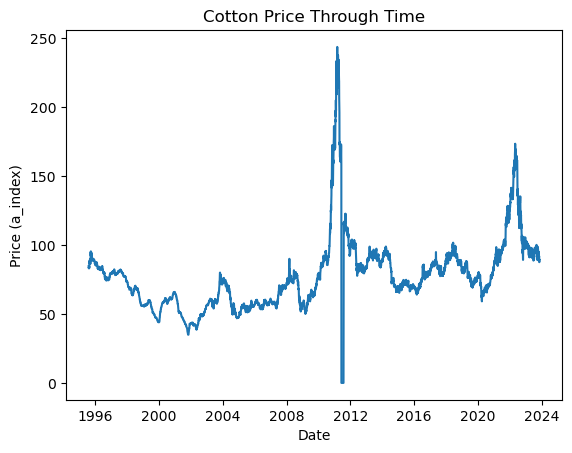

In [5]:
_, ax = plt.subplots()
ax.plot(df['date'], df['a_index'])
ax.set_title('Cotton Price Through Time')
ax.set_ylabel('Price (a_index)')
ax.set_xlabel('Date')

In [ ]:
# Build relative volumes through time
# Get liquidity data
# Can we feed the cutoff into the search space, pull it out in the class somewhere and then apply to
# probability to define a buy and then assess profit. All in the loss function?
# Change k fold cross validation to split dataset into time chunks rather than randomly split

In [ ]:
# df['rsi'] = talib.RSI(df.price, timeperiod=rsi_timeperiod)
# df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(df.price, fastperiod=macd_fastp, slowperiod=macd_slowp, signalperiod=macd_sigp)    
# upper, middle, lower = talib.BBANDS(df.price*100000, timeperiod=bol_period, nbdevup=bol_stdNbr, nbdevdn=bol_stdNbr, matype=0)
# df['bol_upper'], df['bol_middle'], df['bol_lower'] = upper/100000, middle/100000, lower/100000


In [56]:
# df = TSF.build_rolling_features(df, 'volume', roll_lengths = [1, 2, 3, 5, 7, 10, 15, 25, 50, 100])
df = TSF.build_rolling_features(df, 'a_index', roll_lengths = [1, 2, 3, 5, 7, 10, 15, 25, 50, 100])

df = TSF.build_rsi_features(df, 'a_index', rsi_timeperiods=[10, 25, 50, 100, 200])
df = TSF.build_bollinger_features(df, 'a_index', bol_periods=[5, 10, 20, 30, 50, 75, 100], stdNbrs=[2, 4, 6, 8, 10, 12])

            
df = TSF.build_macd_features(df, 'a_index', macd_fastp_values=[10, 12, 14, 16], 
                             macd_slowp_values=[22, 24, 26, 28, 30, 32], 
                             macd_sigp_values=[7, 8, 9, 10, 11, 12])

# df = TSF.build_outcomes(df, 'a_index', 0.01, time_var='date', n_forward_looks = [5, 10, 15, 20]) 
# df = TSF.build_outcomes(df, 'a_index', 0.02, time_var='date', n_forward_looks = [5, 10, 15, 20]) 
df = TSF.build_outcomes(df, 'a_index', 0.05, time_var='date', n_forward_looks = [5, 10, 15, 20, 60]) 
df = TSF.build_outcomes(df, 'a_index', 0.1, time_var='date', n_forward_looks = [5, 10, 15, 20, 60]) 
df = TSF.build_outcomes(df, 'a_index', 0.2, time_var='date', n_forward_looks = [5, 10, 15, 20, 60])

In [57]:
misc_vars = ['date','id','a_index','ice_highest_open_interest_17_months','cc_index','mcx','cepea']
outcome_vars = [x for x in df.columns if 'outcome' in x]
forward_vars = [x for x in df.columns if 'forward' in x]
feat_vars = [x for x in df.columns if x not in misc_vars + forward_vars + outcome_vars]

In [26]:
builder = ModelBuilder()

outcome_var = 'outcome_10_forward_up_0.02'

X_train, X_test, X_valid, y_train, y_test, y_valid = builder.split_train_test_val(df, 
                                                                                  target=outcome_var, 
                                                                                  test_size=0.25, 
                                                                                  dt_var=None, 
                                                                                  split_samples_by='date', 
                                                                                  stratify=outcome_var, 
                                                                                  val_date_from=None, 
                                                                                  seed=1234)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

Test Size:  0.25


In [58]:
cut_point = (df['date'].max() - df['date'].min())*0.8 + df['date'].min()
df_train = df[df['date'] < cut_point].sort_values('date').copy()
df_test = df[df['date'] >= cut_point].sort_values('date').copy()

In [59]:
assert df_train[df_train.date.isin(df_test.date.values)].shape[0] == 0
assert df_test[df_test.date.isin(df_train.date.values)].shape[0] == 0

In [60]:
df_train[outcome_vars].sum()

outcome_5_forward_up_0.05      189
outcome_10_forward_up_0.05     613
outcome_15_forward_up_0.05    1013
outcome_20_forward_up_0.05    1353
outcome_5_forward_up_0.1        19
outcome_10_forward_up_0.1      117
outcome_15_forward_up_0.1      255
outcome_20_forward_up_0.1      403
outcome_5_forward_up_0.2         4
outcome_10_forward_up_0.2       12
outcome_15_forward_up_0.2       44
outcome_20_forward_up_0.2       93
outcome_60_forward_up_0.05    2727
outcome_60_forward_up_0.1     1413
outcome_60_forward_up_0.2      469
dtype: int64

In [139]:
vars = ['outcome_5_forward_up_0.01', 
'outcome_10_forward_up_0.01',    
'outcome_15_forward_up_0.01',    
'outcome_20_forward_up_0.01',    
'outcome_15_forward_up_0.02',     
'outcome_20_forward_up_0.02']     

In [49]:
space_lgb = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 30, 150, 10)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 3, 16, 1)),
    # 'num_leaves': pyll.scope.int(hp.quniform('num_leaves', 2, 150, 1)),
    'min_child_samples': pyll.scope.int(hp.choice('min_child_samples', [5, 10, 20, 30, 40, 50, 75])),
    'reg_alpha': hp.choice('reg_alpha', [0, 0.001, 0.01, 0.1, 0.2]),
    'reg_lambda': hp.choice('reg_lambda', [0, 0.001, 0.01, 0.1, 0.2]),
    'cutoff': hp.quniform('cutoff', 0.01, 1, 0.01),
    # 'outcome_var': hp.choice('outcome_var', outcome_vars)
#     'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
#     'subsample': hp.uniform('subsample', 0.1, 1.0),
#     'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    #,'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

space_lasso = {
  'alpha': hp.uniform('alpha', 0, 1)
}


def calculate_profit(estimator, X, y, cutoff=0.1):
    
    y_hat = estimator.predict_proba(X)[:, 1] 
    
    df = pd.DataFrame({'actual': y, 'pred': y_hat})
    df['buy'] = np.where(df['pred'] >= cutoff, 1, 0)
    
    df_buys = df[df.buy==1].copy()
    
    # buy_correct_rate = df_buys['actual'].mean()
    
    df_buys['outcome'] = np.where(df_buys['actual'] == 1, 1, -1)
    
    net_successful = df_buys['outcome'].sum()
    
    return - net_successful

opt = OptimalModel(df_train=df_train,
                   df_test=df_test,
                   cols=feat_vars, 
                   outcome_var='outcome_20_forward_up_0.1',
                   model_type='lgb', 
                   evals=200, 
                   opt_lib='hp', 
                   search_space=space_lgb, 
                   how_to_tune='cross_val', 
                   eval_metric='auc_pr',
                   n_jobs=-1, 
                   seed=123, 
                   outcome_type='classification', 
                   k=5,
                   stratify_kfold=False)

model, params, trials, importance, errors, cv_scores = opt.build_optimal_model()

Performing model optimisation
  0%|                                   | 0/200 [00:00<?, ?trial/s, best loss=?]

job exception: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py", line 908, in fit
    X, y = self._validate_data(
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 565, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "

  0%|                                   | 0/200 [00:01<?, ?trial/s, best loss=?]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py", line 908, in fit
    X, y = self._validate_data(
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 565, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 921, in check_array
    _assert_all_finite(
  File "/Users/thomaspile/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [53]:
strat.df_train[strat.df_train['pred'] == 1].shape

(0, 346)

params={'boosting_type': 'dart', 'cutoff': 0.02, 'learning_rate': 0.1383359079348521, 'max_depth': 13, 'min_child_samples': 10, 'n_estimators': 40, 'reg_alpha': 0.001, 'reg_lambda': 0}
LGB built in 0.947 seconds
Train AUC: 1.0
Train AUC_PR: 1.0
Test AUC: 0.6760494856825132
Test AUC_PR: 0.13005799785756292


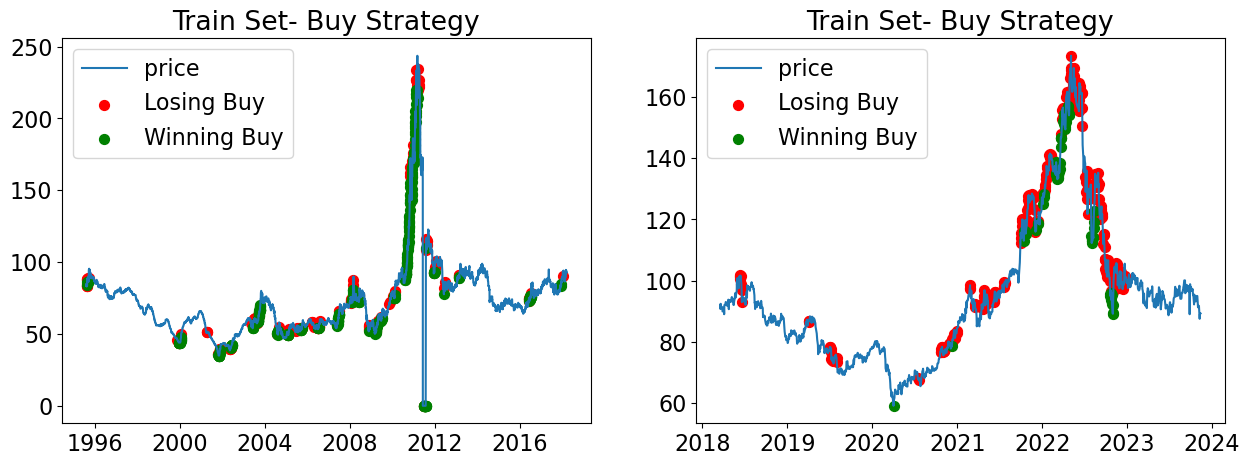

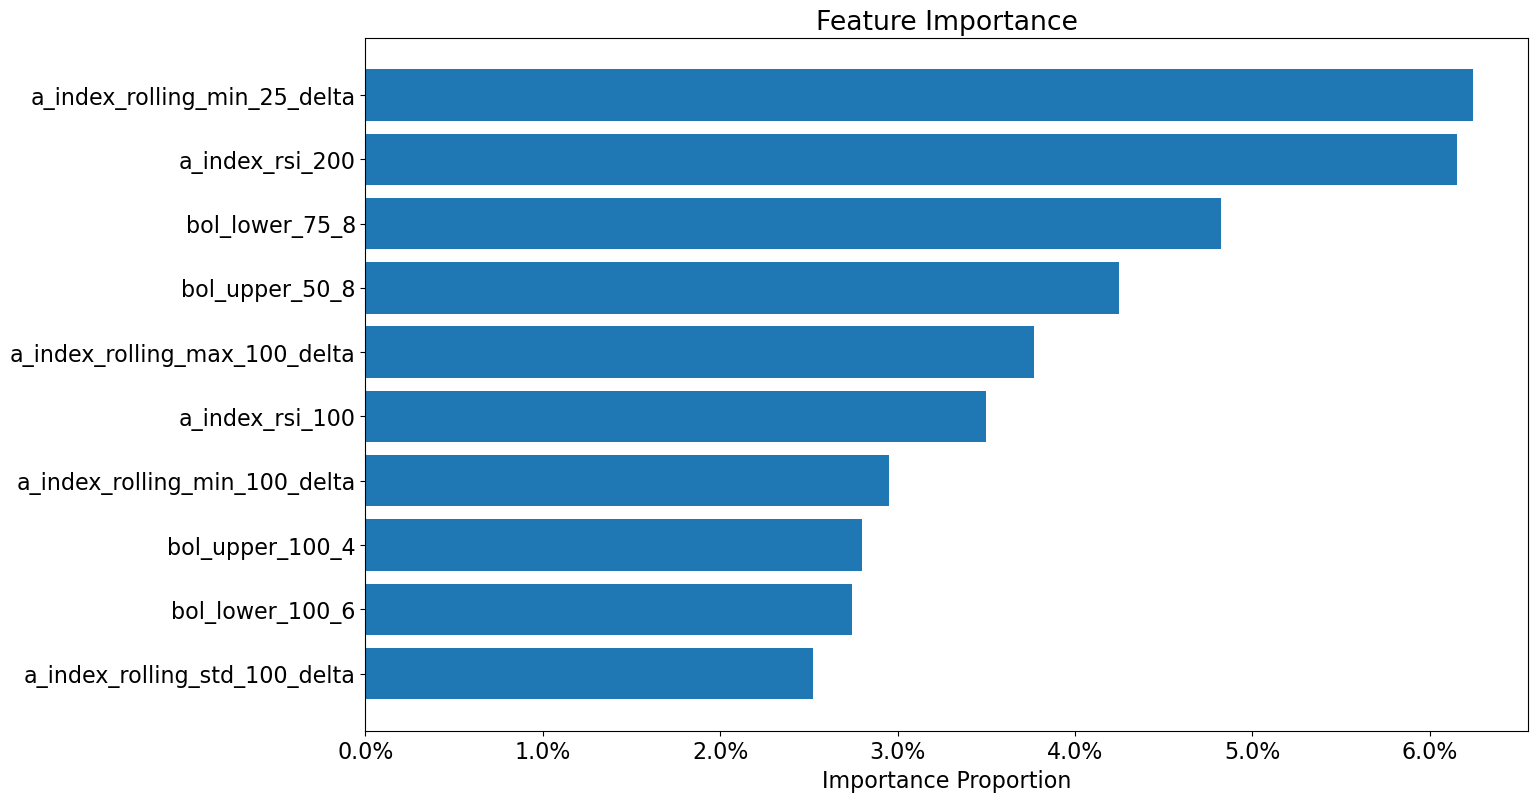

In [51]:
strat = AppliedStrategy(df_train, df_test, feat_vars, params, 
                        outcome_var='outcome_20_forward_up_0.1', 
                        time_var='date', 
                        price_var='a_index')
strat.plot_buys(plot_actuals=False)
strat.plot_validation()

params={'boosting_type': 'gbdt', 'cutoff': 0.74, 'learning_rate': 0.02971581585899725, 'max_depth': 4, 'min_child_samples': 40, 'n_estimators': 50, 'outcome_var': 'outcome_15_forward_up_0.01'}
LGB built in 0.16 seconds
Train AUC: 0.9888203271960326
Train AUC_PR: 0.9681351309870296
Test AUC: 0.816496465043205
Test AUC_PR: 0.6001495011942289


/Users/thomaspile/Documents/GitHub/CREAM/libraries/model_builder.py:706: UserWarning:

FixedFormatter should only be used together with FixedLocator



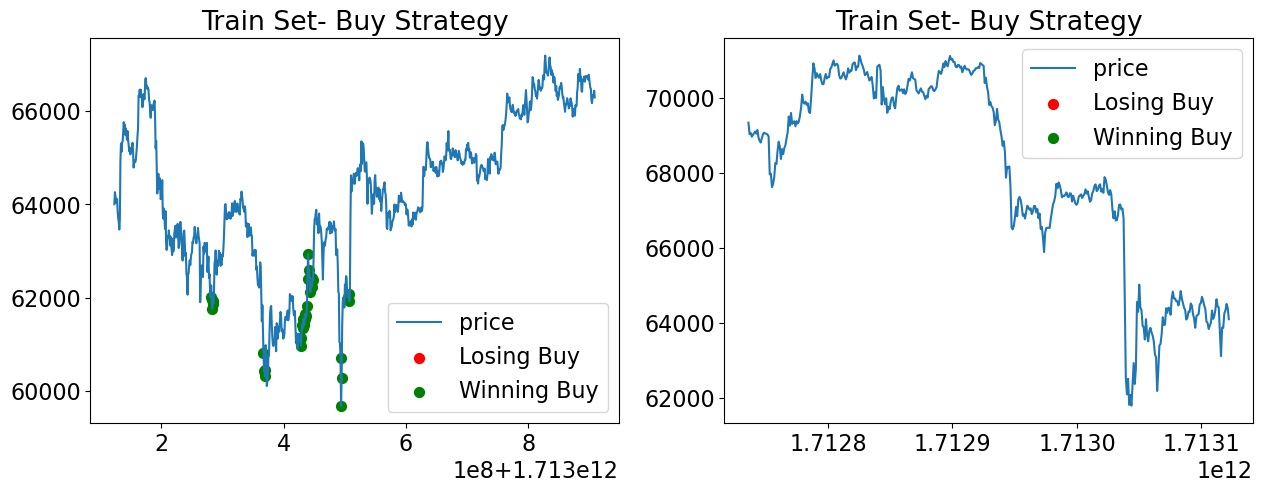

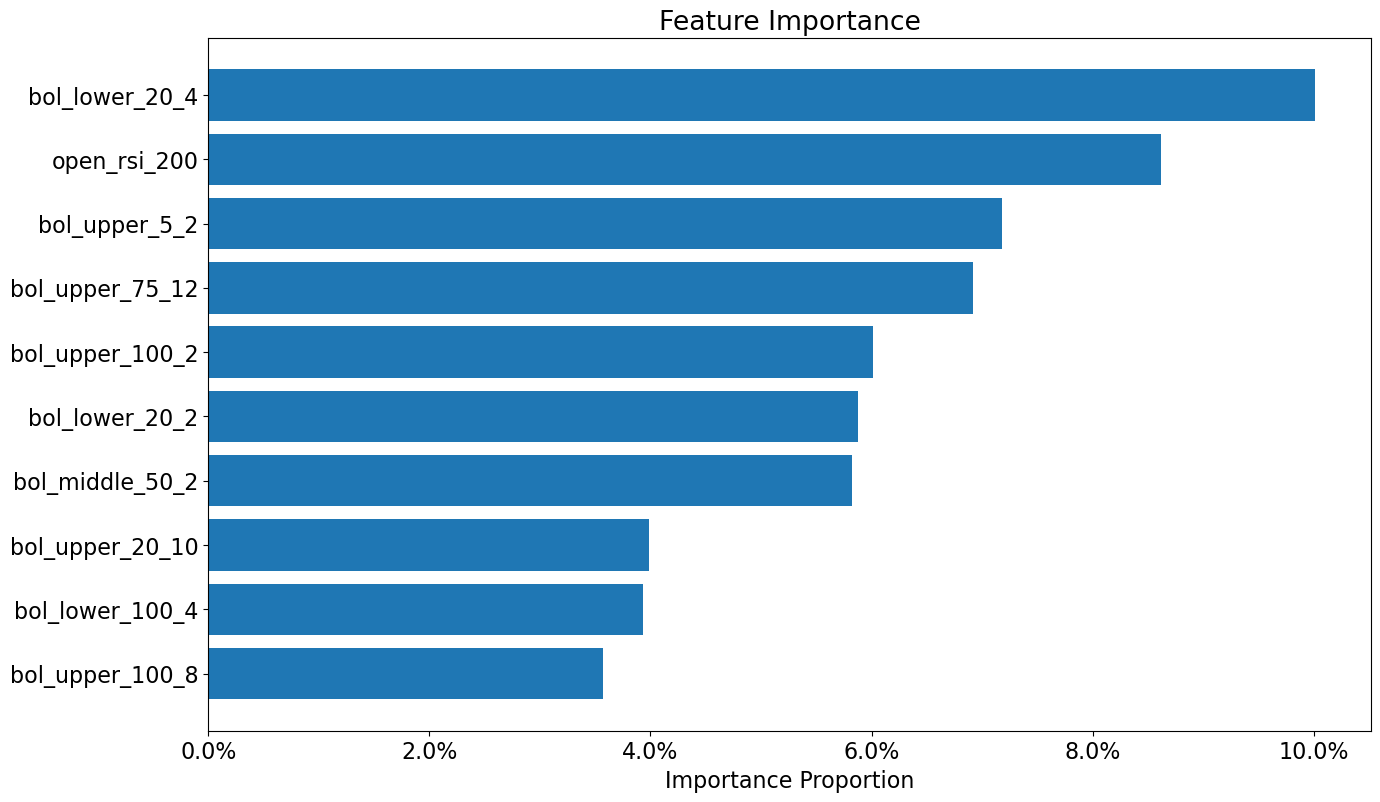

In [65]:
strat = AppliedStrategy(df_train, df_test, feat_vars, params)
strat.plot_buys()
strat.plot_validation()

params={'boosting_type': 'gbdt', 'cutoff': 0.36, 'learning_rate': 0.18026221041217352, 'max_depth': 7, 'min_child_samples': 40, 'n_estimators': 100, 'outcome_var': 'outcome_15_forward_up_0.03'}
LGB built in 0.547 seconds
Train AUC: 1.0
Train AUC_PR: 1.0
Unable to predict on test set
Error returned: Only one class present in y_true. ROC AUC score is not defined in that case.


/Users/thomaspile/Documents/GitHub/CREAM/libraries/model_builder.py:709: UserWarning:

FixedFormatter should only be used together with FixedLocator



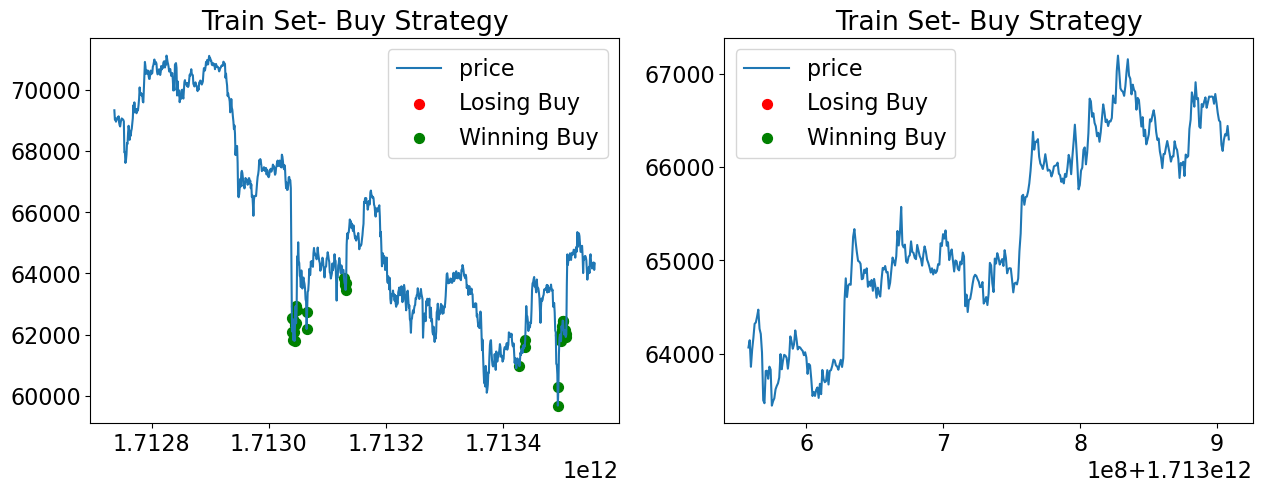

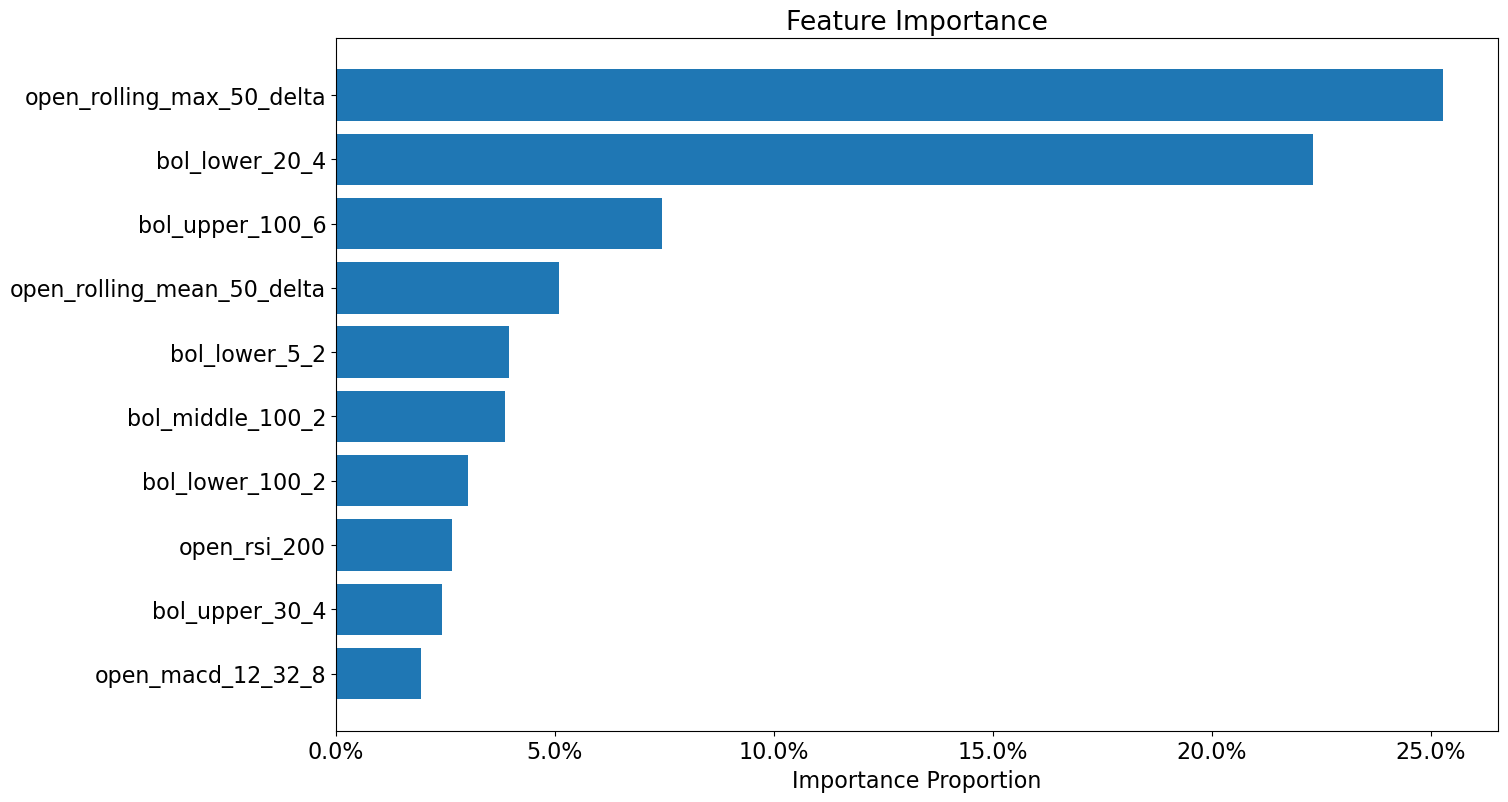

In [87]:
params = {'boosting_type': 'gbdt', 'cutoff': 0.36, 'learning_rate': 0.18026221041217352, 'max_depth': 7, 'min_child_samples': 40, 'n_estimators': 100, 'outcome_var': 'outcome_15_forward_up_0.03'}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_15_forward_up_0.03')
strat.plot_buys()
strat.plot_validation()

params={'boosting_type': 'dart', 'cutoff': 0.84, 'learning_rate': 0.1970890505782278, 'max_depth': 11, 'min_child_samples': 30, 'n_estimators': 30}
LGB built in 0.42 seconds
Train AUC: 1.0
Train AUC_PR: 0.9999999999999999
Test AUC: 0.6151866151866151
Test AUC_PR: 0.06192686985381348


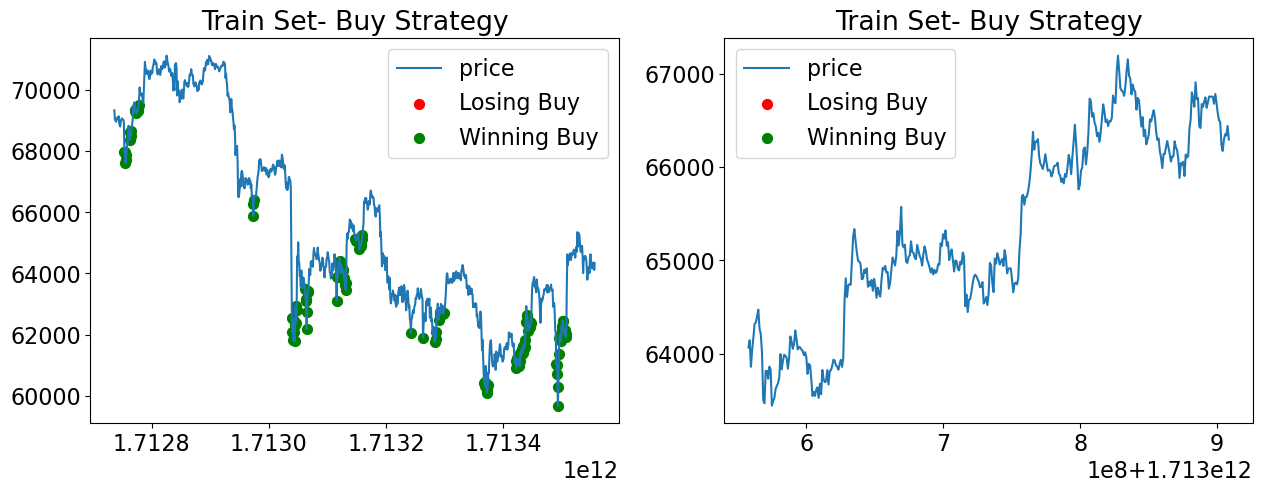

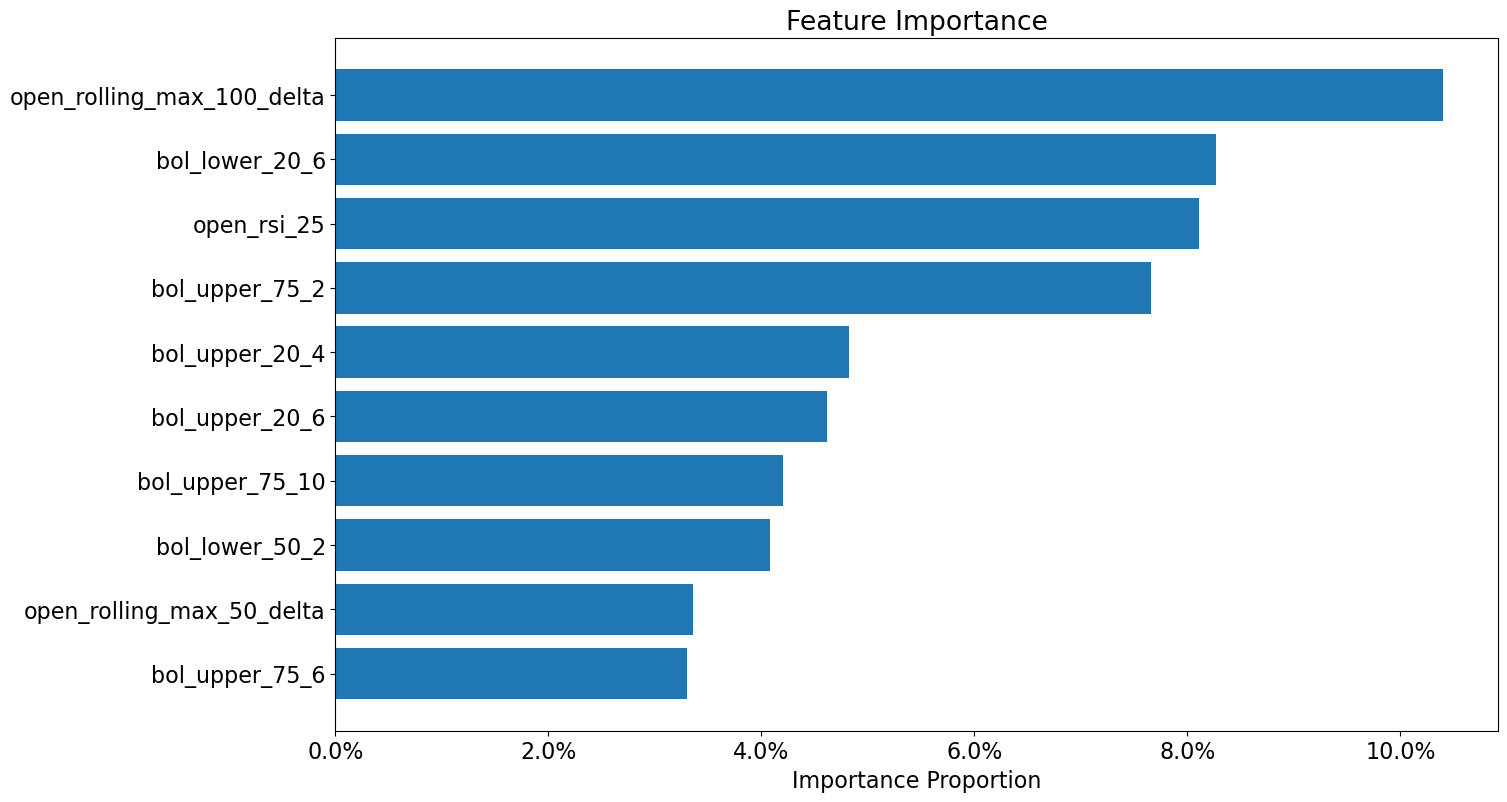

In [95]:
params = {'boosting_type': 'dart', 'cutoff': 0.84, 'learning_rate': 0.1970890505782278, 'max_depth': 11, 'min_child_samples': 30, 'n_estimators': 30}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys()
strat.plot_validation()

LGB built in 0.109 seconds
Train AUC: 0.9945898544908666
Train AUC_PR: 0.974354205337692
Test AUC: 0.6295967741935483
Test AUC_PR: 0.12432316172668137


/Users/thomaspile/Documents/GitHub/CREAM/libraries/model_builder.py:706: UserWarning:

FixedFormatter should only be used together with FixedLocator



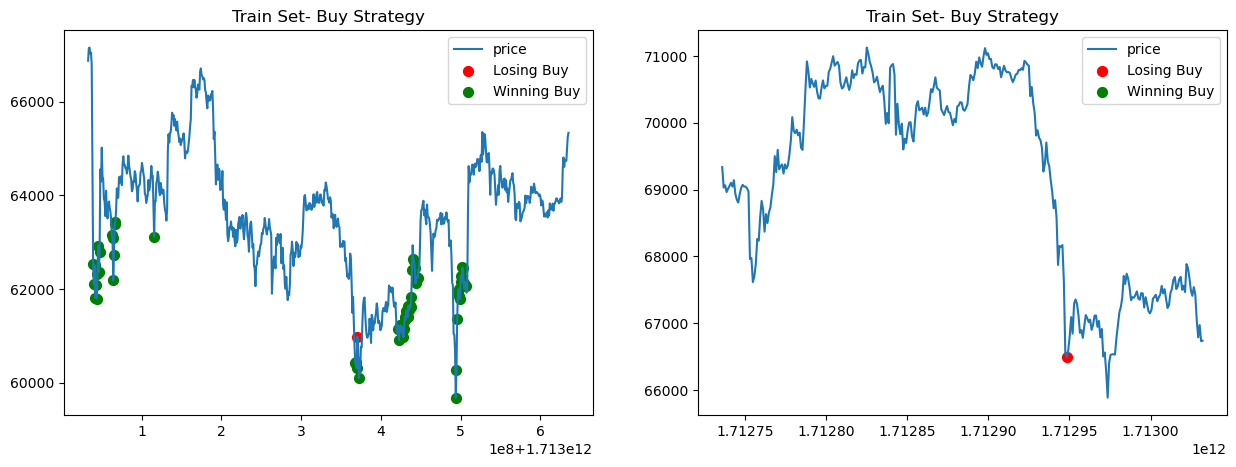

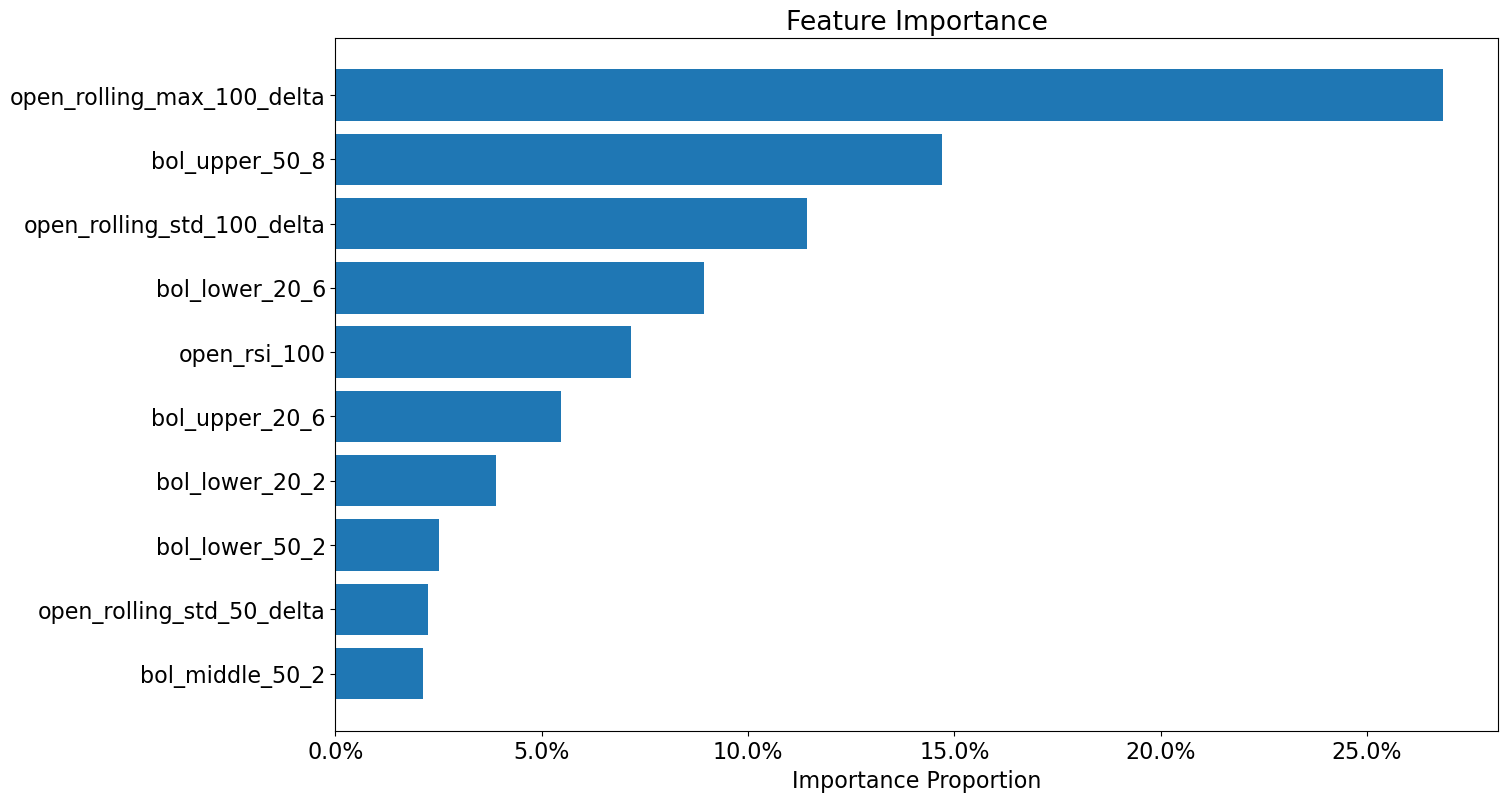

In [32]:
params = {'boosting_type': 'dart', 'cutoff': 0.6900000000000001, 'learning_rate': 0.3151037186620746, 'max_depth': 8, 'min_child_samples': 5, 'n_estimators': 90, 'num_leaves': 2}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys()
strat.plot_validation()

LGB built in 0.772 seconds
Train AUC: 0.9964357317888171
Train AUC_PR: 0.9845249915729507
Test AUC: 0.7356725146198831
Test AUC_PR: 0.43256487562114954


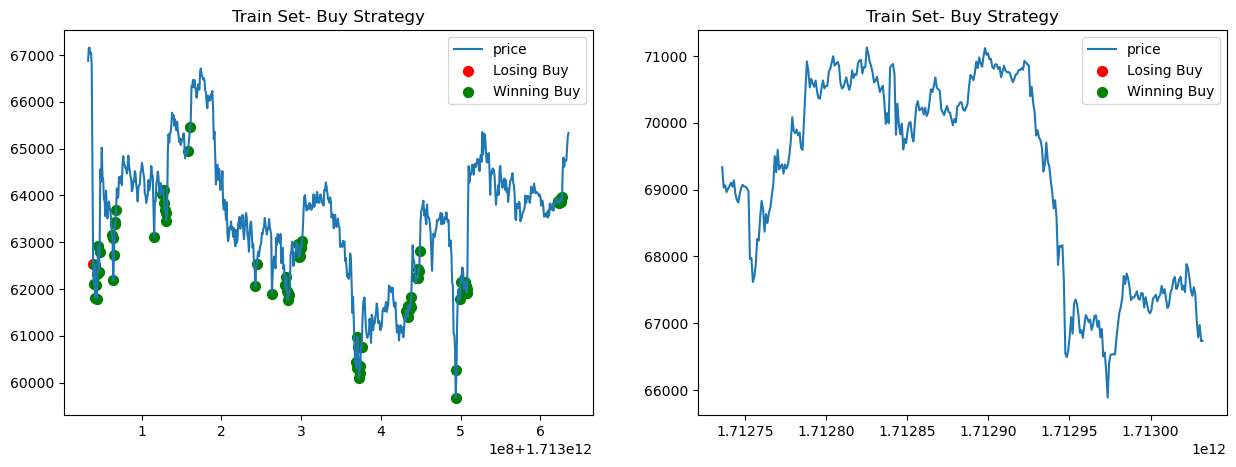

In [28]:
params = {'boosting_type': 'dart', 'cutoff': 0.72, 'learning_rate': 0.056238894214083054, 'max_depth': 10, 'min_child_samples': 50, 'n_estimators': 150, 'num_leaves': 90}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_10_forward_up_0.01')
strat.plot_buys()

LGB built in 1.928 seconds
Train AUC: 1.0
Train AUC_PR: 1.0
Test AUC: 0.7964714714714715
Test AUC_PR: 0.23779727923365826


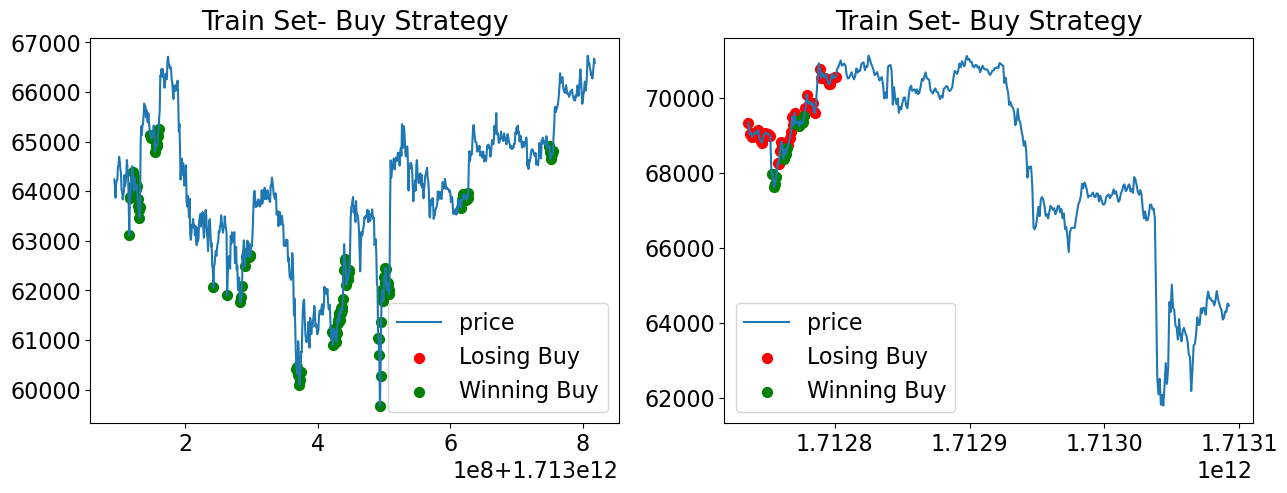

In [44]:
params = {'boosting_type': 'gbdt', 'cutoff': 0.79, 'learning_rate': 0.043528325705932985, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 140, 'num_leaves': 141}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys()

LGB built in 1.534 seconds
Train AUC: 1.0
Train AUC_PR: 1.0000000000000002
Test AUC: 0.9861290322580645
Test AUC_PR: 0.7392823060349415


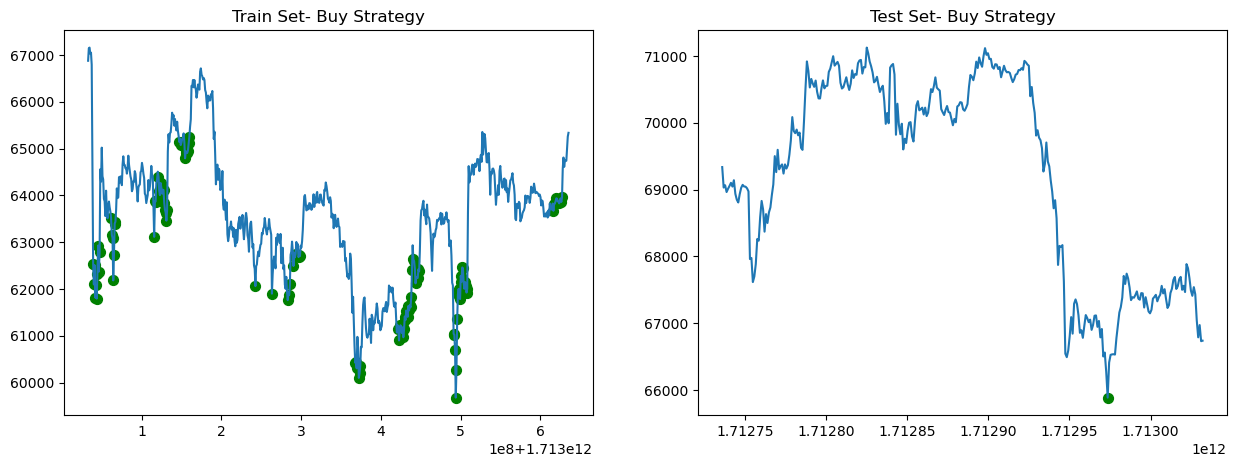

In [13]:
params = {'boosting_type': 'gbdt', 'cutoff': 0.79, 'learning_rate': 0.043528325705932985, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 140, 'num_leaves': 141}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys()

LGB built in 0.259 seconds
Train AUC: 0.9862888482632541
Train AUC_PR: 0.9345741387283282
Test AUC: 0.958225806451613
Test AUC_PR: 0.4030537280701755


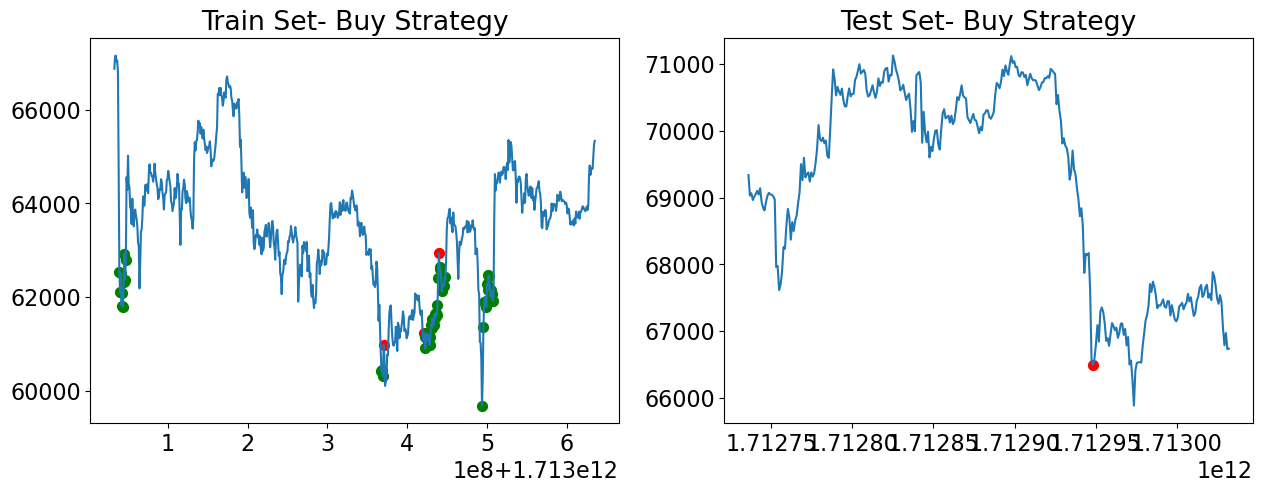

In [89]:
params = {'boosting_type': 'dart', 'cutoff': 0.5, 'learning_rate': 0.0180800787740303, 'max_depth': 4, 'min_child_samples': 50, 'n_estimators': 90, 'num_leaves': 26}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys()

LGB built in 1.237 seconds
Train AUC: 1.0
Train AUC_PR: 1.0000000000000004
Test AUC: 0.9765322580645162
Test AUC_PR: 0.6414462116102142


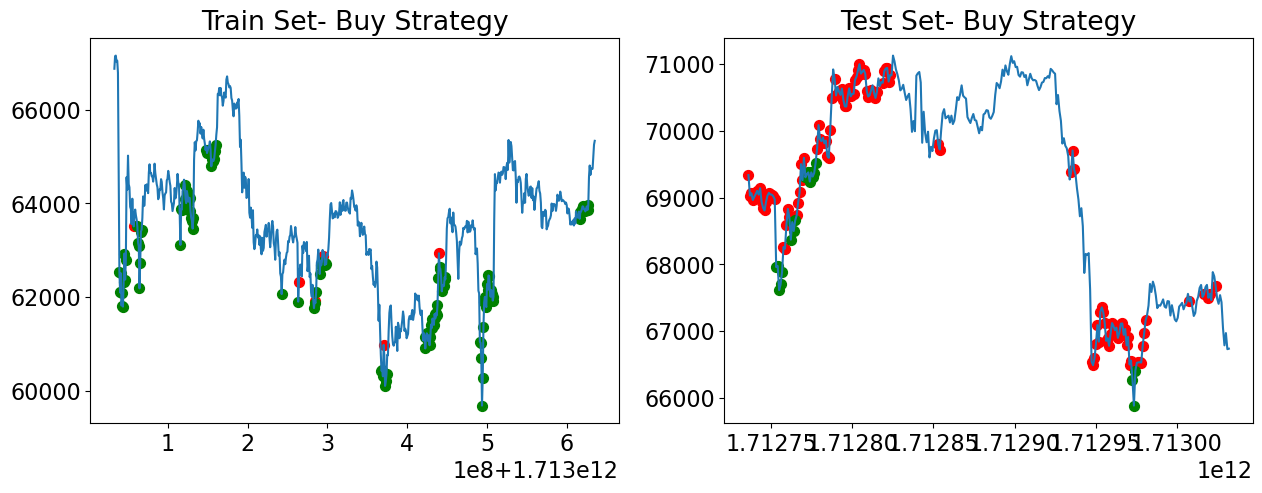

In [86]:
params = {'boosting_type': 'dart', 'cutoff': 0.005, 'learning_rate': 0.17248888953698474, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 80, 'num_leaves': 82, 'verbose': -1}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys()

LGB built in 1.409 seconds
Train AUC: 1.0
Train AUC_PR: 1.0000000000000002
Test AUC: 0.9473387096774193
Test AUC_PR: 0.41361839918968407


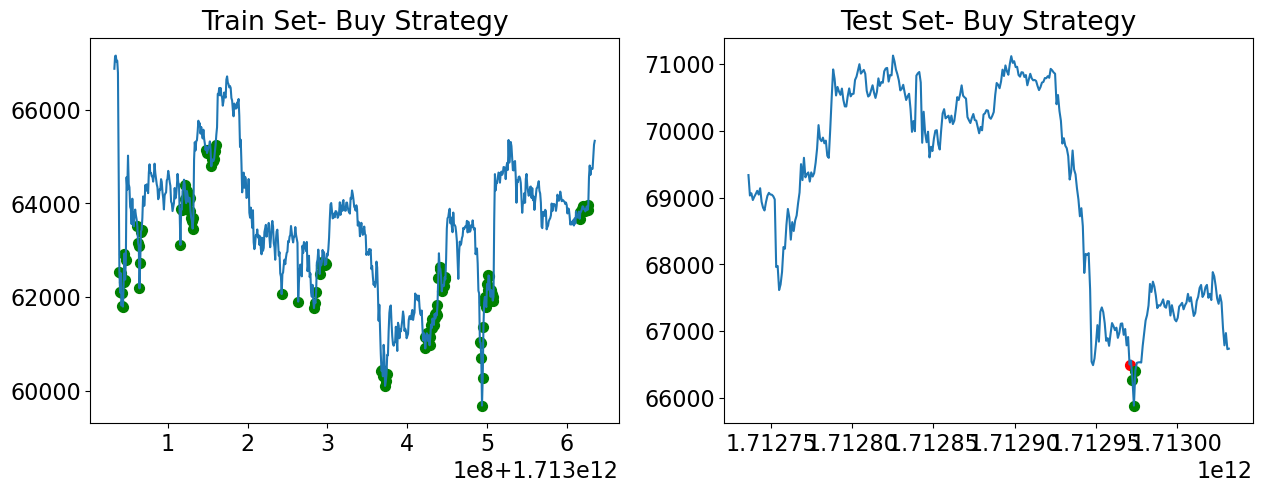

In [85]:
params = {'boosting_type': 'gbdt', 'cutoff': 0.3, 'learning_rate': 0.09641013865076159, 'max_depth': 12, 'min_child_samples': 5, 'n_estimators': 60, 'num_leaves': 112, 'verbose': -1}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys()

LGB built in 0.918 seconds
Train AUC: 1.0
Train AUC_PR: 1.0
Test AUC: 0.9483870967741935
Test AUC_PR: 0.40034329665095847


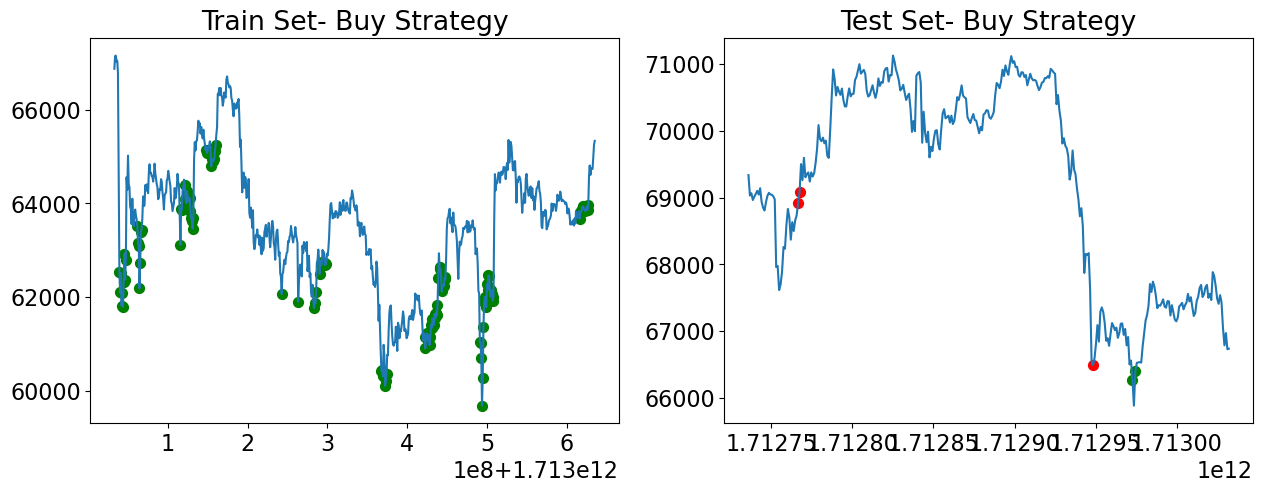

In [83]:
params = {'boosting_type': 'gbdt', 'cutoff': 0.3, 'learning_rate': 0.18206361462104229, 'max_depth': 10, 'min_child_samples': 5, 'n_estimators': 40, 'num_leaves': 146, 'verbose': -1}
strat = AppliedStrategy(df_train, df_test, feat_vars, params, outcome_var='outcome_20_forward_up_0.02')
strat.plot_buys(label_wins=True)

In [ ]:
# Test AUC: 0.9483870967741935
# Test AUC_PR: 0.40034329665095847
# Best parameters found: {'boosting_type': 'gbdt', 'cutoff': 0.3, 'learning_rate': 0.18206361462104229, 'max_depth': 10, 'min_child_samples': 5, 'n_estimators': 40, 'num_leaves': 146, 'verbose': -1}


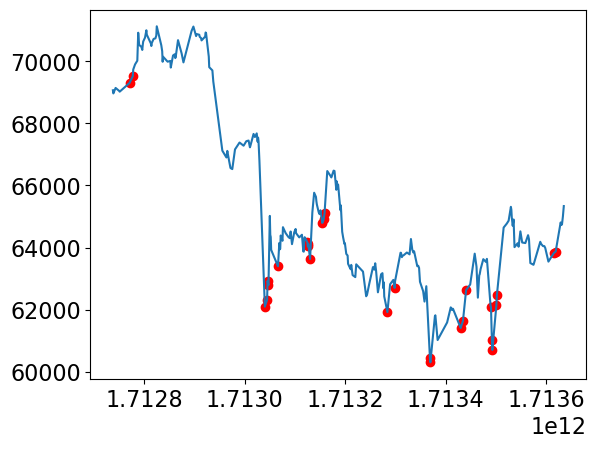

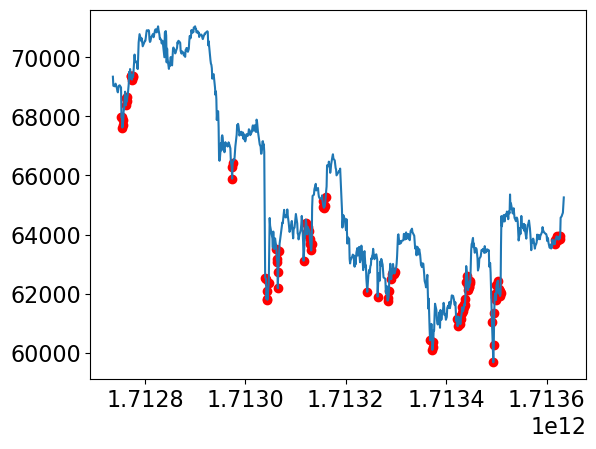

In [16]:
# Test AUC: 0.9925757575757576
# Test AUC_PR: 0.951571084480723
# Best parameters found: {'boosting_type': 'gbdt', 'cutoff': 0.01, 'learning_rate': 0.1437087899983411, 'max_depth': 12, 'min_child_samples': 5, 'n_estimators': 150, 'num_leaves': 133, 'outcome_var': 'outcome_20_forward_up_0.02'}
# Cross validation scores: [-20 -19 -17 -15 -19]

def plot_buys(df_in, cutoff):
    
    df = df_in.copy()
    df = df.sort_values('open_time')
    df['buy'] = np.where(df['pred'] >= cutoff, df['open'], np.nan)
    
    _, ax = plt.subplots()
    
    ax.plot(df['open_time'], df['open'])
    ax.scatter(df['open_time'], df['buy'], color='r')
    
plot_buys(df_test, params['cutoff'])
plot_buys(df_train, params['cutoff'])

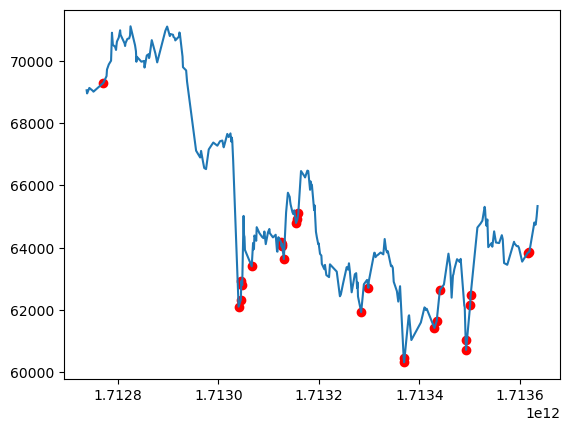

In [14]:
# Test AUC: 0.989090909090909
# Test AUC_PR: 0.9112806628064007
# Best parameters found: {'boosting_type': 'gbdt', 'cutoff': 0.3, 'learning_rate': 0.3166268778570664, 'max_depth': 6, 'min_child_samples': 10, 'n_estimators': 130, 'num_leaves': 127, 'outcome_var': 'outcome_20_forward_up_0.02'}
# Cross validation scores: [-18 -19 -15 -15 -21]

def plot_buys(df_in, cutoff):
    
    df = df_in.copy()
    df = df.sort_values('open_time')
    df['buy'] = np.where(df['pred'] >= cutoff, df['open'], np.nan)
    
    _, ax = plt.subplots()
    
    ax.plot(df['open_time'], df['open'])
    ax.scatter(df['open_time'], df['buy'], color='r')
    
plot_buys(df_test, params['cutoff'])

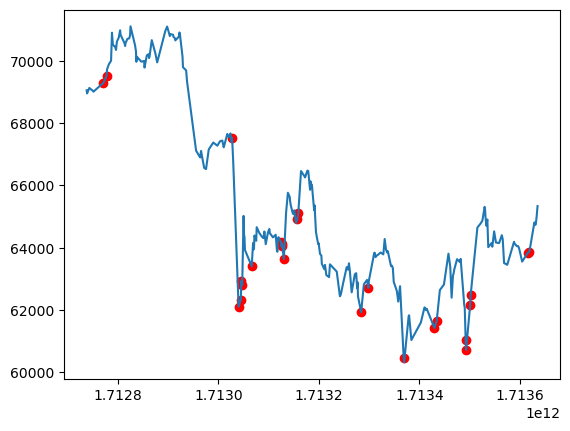

In [25]:
def plot_buys(df_in, cutoff):
    
    df = df_in.copy()
    df = df.sort_values('open_time')
    df['buy'] = np.where(df['pred'] >= cutoff, df['open'], np.nan)
    
    _, ax = plt.subplots()
    
    ax.plot(df['open_time'], df['open'])
    ax.scatter(df['open_time'], df['buy'], color='r')
    
plot_buys(df_test, params['cutoff'])

In [14]:
df_test[['outcome_20_forward_up_0.02', 'pred']].sort_values('pred')

,outcome_20_forward_up_0.02,pred
802,0,0.001670
882,0,0.001976
877,0,0.001978
888,0,0.002076
883,0,0.002213
...,...,...
433,1,0.863971
776,1,0.871864
39,1,0.878504
432,1,0.915298


In [ ]:
{'boosting_type': 'gbdt', 'cutoff': 0.05, 'learning_rate': 0.44639840258955144, 'max_depth': 6, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 22, 'outcome_var': 'outcome_10_forward_up_0.02'}

In [ ]:
{'boosting_type': 'goss', 'cutoff': 0.2, 'learning_rate': 0.4392765201498472, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 70, 'num_leaves': 73, 'outcome_var': 'outcome_10_forward_up_0.02'}

In [143]:
{'boosting_type': 'dart', 'learning_rate': 0.48616222218501326, 'max_depth': 10, 'min_child_samples': 50, 'n_estimators': 150, 'num_leaves': 110}

In [15]:
plot_strategy(df_test, cutoff=0.2)

In [88]:
{'boosting_type': 'gbdt', 'learning_rate': 0.49690661731902125, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 100, 'num_leaves': 16}

{'boosting_type': 'gbdt',
 'learning_rate': 0.49690661731902125,
 'max_depth': 10,
 'min_child_samples': 30,
 'n_estimators': 100,
 'num_leaves': 16}

In [19]:
# precision, recall, _ = metrics.precision_recall_curve(df_test[outcome_var], df_test['pred'])
# auc_pr = metrics.auc(recall, precision)
# auc_pr

In [96]:
df_test.sort_values('pred').plot(x='open_rsi_50', y='pred', kind='scatter')

KeyError: 'pred'